In [ ]:
!pip install "dask[complete]"
!pip install pyarrow pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 53.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 102.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.6/242.6 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.1/85.1 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 2.9 MB/s eta 0:00:00
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 4.6.4
    Uninstalling importlib-metadata-4.6.4:
      Successfully uninstalled importlib-metadata-4.6.4


In [ ]:
!pip install tensorflow
!pip install keras

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import dask.dataframe as dd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cdist
import numpy as np
from warnings import filterwarnings
filterwarnings('ignore')
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.losses import mse
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, LayerNormalization
from sklearn.metrics import recall_score, precision_score,accuracy_score
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Dense, Lambda, Layer

In [ ]:
# 1. Load Data from Parquet Files
data_dir = '/content/drive/MyDrive/Data_hasking'
# Get a list of all parquet files (first 40 days) and load them into a Dask DataFrame
file_list = sorted(glob.glob(f"{data_dir}/*.parquet"))[:40]
ddf = dd.read_parquet(file_list)

In [ ]:
# 2. Load Customer Data
tb_customers = dd.read_parquet('/content/drive/MyDrive/TB_CUSTOMERS.parquet')
tb_customers_df = tb_customers.compute()


# Filter individual customers (CUSTOMER_TYPE == 'Cá nhân')
tb_customers_individual_df = tb_customers_df[tb_customers_df["CUSTOMER_TYPE"] == "Cá nhân"]
individual_customers = tb_customers_individual_df["CUST_CUSTNO"].unique().tolist()

In [ ]:
# 3. Filter Transactions for Individual Customers
ddf_filtered = ddf[['CUST_CUSTNO', 'AMOUNT',  'VALUEDATE']]
df_individual = ddf_filtered[ddf_filtered['CUST_CUSTNO'].isin(individual_customers)]
df_individual_df = df_individual.compute()

In [ ]:
df_individual_df

,CUST_CUSTNO,AMOUNT,VALUEDATE
0,a168d638771f6240e978956399d9f16621b02655b20ae8...,-9600.00,20230801
1,4fd201b58b6b81ad3366160ff82f3d53f622e0290a57db...,-100.00,20230801
2,52dcdc6af49899ae1dfae36d4eee1625fe717ac6897c2b...,-99.20,20230801
3,db34f14574441e3f42d7ea1d5299204ea481f9ac8f5ff5...,-120.00,20230801
4,49454b2d0968a2714066486a540ac8f0a57ee432cc3ca4...,-120.00,20230801
...,...,...,...
623550,b7a87502f6fc0186f4121a76a9780cb36b693e1582b8ab...,100000.00,20230909
623551,6e9f203c3dc24face6bff660ee9b32b7ea16d0efb9dfe1...,70267.53,20230909
623552,64b35de667d8ce5291f80e98f3da63931855d251eb8cb2...,52394.52,20230909
623553,27be2fbe7acca08d73d7160716dd1ae073a22ff06d6038...,41294.16,20230909


In [ ]:
# 4. Convert VALUEDATE to Datetime and Extract Date
df_individual_df['VALUEDATE'] = pd.to_datetime(df_individual_df['VALUEDATE'], errors='coerce')
df_individual_df['DATE_ONLY'] = df_individual_df['VALUEDATE'].dt.date

In [ ]:
# # 5. Separate Deposits and Withdrawals
chunk_size = 100000
num_rows = df_individual_df.shape[0]

df_deposits_list = []
df_withdrawals_list = []

for start in range(0, num_rows, chunk_size):
    chunk = df_individual_df[start:start + chunk_size]
    chunk['AMOUNT'] = chunk['AMOUNT'].fillna(0)
    df_deposits_list.append(chunk[chunk['AMOUNT'] > 0])
    df_withdrawals_list.append(chunk[chunk['AMOUNT'] < 0])

df_deposits = pd.concat(df_deposits_list, ignore_index=True)
df_withdrawals = pd.concat(df_withdrawals_list, ignore_index=True)

In [ ]:

# 6. Aggregate by Customer and Date
daily_deposits = df_deposits.groupby(['CUST_CUSTNO', 'DATE_ONLY'])['AMOUNT'].sum().reset_index(name='total_deposits')
daily_withdrawals = df_withdrawals.groupby(['CUST_CUSTNO', 'DATE_ONLY'])['AMOUNT'].sum().reset_index(name='total_withdrawals')

In [ ]:
# 7. Merge Deposits and Withdrawals Data
transactions = pd.merge(daily_deposits, daily_withdrawals, on=['CUST_CUSTNO', 'DATE_ONLY'], how='outer')
# Fill missing values (no deposits/withdrawals) with 0
transactions['total_deposits'].fillna(0, inplace=True)
transactions['total_withdrawals'].fillna(0, inplace=True)

#1. Data Preparation (Log Transformations)

In [ ]:
# 8. Log Transform the Data
transactions['log_total_deposits'] = np.log1p(transactions['total_deposits'])
transactions['log_total_withdrawals'] = np.log1p(transactions['total_withdrawals'].abs())

In [ ]:
# Prepare the data for anomaly detection
features = transactions[['log_total_deposits', 'log_total_withdrawals']].values

In [ ]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

In [ ]:
print(f"Original input dimension: {features_scaled.shape}")

Original input dimension: (6128277, 2)


#2. VAE for Local Patterns

Epoch 1/100
10773/10773 [==============================] - 68s 6ms/step - loss: 1.0115 - val_loss: 0.9406
Epoch 2/100
10773/10773 [==============================] - 66s 6ms/step - loss: 0.9996 - val_loss: 0.9771
Epoch 3/100
10773/10773 [==============================] - 67s 6ms/step - loss: 0.9938 - val_loss: 0.9650
Epoch 4/100
10773/10773 [==============================] - 66s 6ms/step - loss: 0.9930 - val_loss: 0.9868
Epoch 5/100
10773/10773 [==============================] - 66s 6ms/step - loss: 0.9931 - val_loss: 0.9885
Epoch 6/100
10773/10773 [==============================] - 66s 6ms/step - loss: 0.9930 - val_loss: 0.9824
Epoch 7/100
10773/10773 [==============================] - 67s 6ms/step - loss: 0.9927 - val_loss: 0.9990
Epoch 8/100
10773/10773 [==============================] - 67s 6ms/step - loss: 0.9925 - val_loss: 0.9805
Epoch 9/100
10773/10773 [==============================] - 67s 6ms/step - loss: 0.9925 - val_loss: 0.9752
Epoch 10/100
10773/10773 [====================

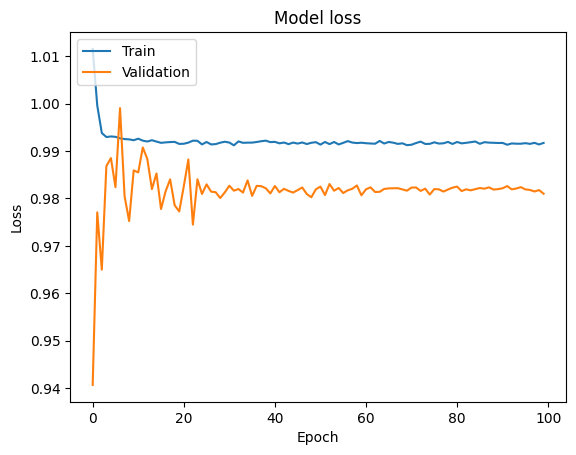

In [ ]:
# Adjust latent dimension, batch size, learning rate, and epochs
latent_dim = 128  # Increased latent space dimension for better feature capture
batch_size = 512  # Reduced batch size to allow better generalization
epochs = 100  # Increased epochs for better convergence

# Build the Encoder model
def build_encoder(input_dim):
    inputs = layers.Input(shape=(input_dim,))
    h = layers.Dense(128, activation=None)(inputs)  # No activation, we'll add LeakyReLU
    h = layers.LeakyReLU(alpha=0.1)(h)  # LeakyReLU for better gradient flow
    h = layers.Dropout(0.2)(h)  # Dropout for regularization
    h = layers.Dense(64, activation=None)(h)
    h = layers.LeakyReLU(alpha=0.1)(h)
    h = layers.Dropout(0.2)(h)
    z_mean = layers.Dense(latent_dim)(h)
    z_log_var = layers.Dense(latent_dim)(h)
    return Model(inputs, [z_mean, z_log_var])

# Build the Decoder model
def build_decoder(output_dim):
    latent_inputs = layers.Input(shape=(latent_dim,))
    h = layers.Dense(64, activation=None)(latent_inputs)
    h = layers.LeakyReLU(alpha=0.1)(h)
    h = layers.Dense(128, activation=None)(h)
    h = layers.LeakyReLU(alpha=0.1)(h)
    outputs = layers.Dense(output_dim)(h)
    return Model(latent_inputs, outputs)

# Sampling layer to sample from latent space
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# VAE Loss Function
def vae_loss(inputs, reconstructed, z_mean, z_log_var):
    reconstruction_loss = tf.reduce_mean(tf.square(inputs - reconstructed), axis=-1)  # MSE loss
    kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)  # KL divergence
    return reconstruction_loss + kl_loss

# Build the VAE model
def build_vae(encoder, decoder):
    inputs = layers.Input(shape=(2,))  # Input for 2 features: log_total_deposits, log_total_withdrawals
    z_mean, z_log_var = encoder(inputs)
    z = Sampling()([z_mean, z_log_var])
    reconstructed = decoder(z)
    vae = Model(inputs, reconstructed)
    vae.add_loss(vae_loss(inputs, reconstructed, z_mean, z_log_var))  # Add VAE loss
    return vae

# Create the VAE model
encoder = build_encoder(2)
decoder = build_decoder(2)
vae = build_vae(encoder, decoder)

# Compile the VAE with the Adam optimizer and a learning rate schedule
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3, decay_steps=10000, decay_rate=0.9)  # Reduce learning rate over time

vae.compile(optimizer=Adam(learning_rate=lr_schedule))

# Train the VAE
history = vae.fit(features_scaled, features_scaled, epochs=epochs, batch_size=batch_size, validation_split=0.1)

# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#3. Transformer for Long-Term Dependency Analysis

In [ ]:
# Step 1: Extract the latent space representation from the VAE
z_mean, z_log_var = encoder.predict(features_scaled)  # Assuming encoder is already defined and trained

191509/191509 [==============================] - 251s 1ms/step


In [ ]:
# Step 2: Create a sequence dataset for the Transformer
def create_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length + 1):
        sequences.append(data[i:i + sequence_length])
    return np.array(sequences)

sequence_length = 7  # Number of days or sequences to capture long-term dependency
sequences = create_sequences(z_mean, sequence_length)

# Step 3: Split data into train and test sets
train_sequences, test_sequences = train_test_split(sequences, test_size=0.2, random_state=42)

# Step 4: Define the Transformer model
def build_transformer_model(input_shape, num_heads, ff_dim, num_transformer_blocks):
    inputs = keras.Input(shape=input_shape)

    # First Transformer Block
    x = layers.MultiHeadAttention(num_heads=num_heads, key_dim=input_shape[-1])(inputs, inputs)
    x = layers.LayerNormalization(epsilon=1e-6)(x + inputs)  # Add & Norm
    x = layers.Dense(ff_dim, activation="relu")(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(input_shape[-1])(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x + inputs)  # Add & Norm

    # Additional Transformer Blocks (if any)
    for _ in range(num_transformer_blocks - 1):
        residual = x
        x = layers.MultiHeadAttention(num_heads=num_heads, key_dim=input_shape[-1])(x, x)
        x = layers.LayerNormalization(epsilon=1e-6)(x + residual)
        x = layers.Dense(ff_dim, activation="relu")(x)
        x = layers.Dropout(0.1)(x)
        x = layers.Dense(input_shape[-1])(x)
        x = layers.LayerNormalization(epsilon=1e-6)(x + residual)

    # Final dense layer and output
    x = layers.Dense(input_shape[-1], activation="relu")(x)
    x = layers.Dropout(0.1)(x)
    outputs = layers.Dense(input_shape[-1])(x)  # Output size should match latent_dim

    return keras.Model(inputs=inputs, outputs=outputs)

# Step 5: Hyperparameters for the Transformer model
num_heads = 4  # Number of attention heads
ff_dim = 64  # Feedforward dimension size
num_transformer_blocks = 2  # Number of transformer blocks

transformer_model = build_transformer_model(
    input_shape=(sequence_length, z_mean.shape[-1]),  # Input shape based on sequence length and latent dimension
    num_heads=num_heads,
    ff_dim=ff_dim,
    num_transformer_blocks=num_transformer_blocks
)

# Step 6: Compile the Transformer model
transformer_model.compile(optimizer=Adam(learning_rate=1e-4), loss="mse")

# Step 7: Add EarlyStopping callback to prevent overfitting
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Step 8: Train the Transformer model
transformer_model.fit(
    train_sequences, train_sequences,  # Training data as input and output (autoencoder style)
    epochs=50,  # Number of epochs
    batch_size=64,  # Adjust batch size based on available resources
    validation_split=0.1,  # Split some data for validation
    callbacks=[early_stopping]  # Include early stopping
)

# Step 9: Evaluate the model on test data
loss = transformer_model.evaluate(test_sequences, test_sequences, verbose=0)
print(f"Transformer Model Loss on Test Data: {loss}")

# Step 10: Get the transformed latent representation from the Transformer model
transformed_latent_representation = transformer_model.predict(sequences)


Epoch 1/50
68944/68944 [==============================] - 1800s 26ms/step - loss: 3.6199e-04 - val_loss: 3.3650e-05
Epoch 2/50
68944/68944 [==============================] - 1786s 26ms/step - loss: 1.8997e-04 - val_loss: 3.2655e-05
Epoch 3/50
68944/68944 [==============================] - 1787s 26ms/step - loss: 1.8997e-04 - val_loss: 3.1027e-05
Epoch 4/50
68944/68944 [==============================] - 1786s 26ms/step - loss: 1.8968e-04 - val_loss: 3.1832e-05
Epoch 5/50
68944/68944 [==============================] - 1790s 26ms/step - loss: 1.8990e-04 - val_loss: 3.1640e-05
Epoch 6/50
68944/68944 [==============================] - 1788s 26ms/step - loss: 1.8959e-04 - val_loss: 3.5074e-05
Epoch 7/50
68944/68944 [==============================] - 1797s 26ms/step - loss: 1.8981e-04 - val_loss: 3.1656e-05
Epoch 8/50
68944/68944 [==============================] - 1792s 26ms/step - loss: 1.8958e-04 - val_loss: 3.2846e-05
Epoch 9/50
68944/68944 [==============================] - 1791s 26ms/ste

#4. Anomaly Detection (Reconstruction Error) for the VAE-Transformer

In [ ]:
# Step 11: Use transformed_latent_representation for further anomaly detection
reconstruction_error = np.mean(np.square(sequences - transformed_latent_representation), axis=-1)

# Step 12: Set a threshold based on reconstruction error (95th percentile)
threshold = np.percentile(reconstruction_error, 95)
print(f"Anomaly Detection Threshold: {threshold}")

# Identify anomalies
anomalies = reconstruction_error > threshold
print(f"Number of anomalies detected: {np.sum(anomalies)}")

# Optional: Save model if needed
transformer_model.save('transformer_model.h5')

Anomaly Detection Threshold: 3.5898319765692577e-06
Number of anomalies detected: 2144893


In [ ]:
# Rule-based anomalies
rule_15_anomalies = transactions[
    (transactions['total_deposits'] >= 6000000) &
    (transactions['total_withdrawals'].abs() >= 0.95 * transactions['total_deposits'])
]
rule_15_anomalies

,CUST_CUSTNO,DATE_ONLY,total_deposits,total_withdrawals,log_total_deposits,log_total_withdrawals
612,000975b0ee367856502b174994023821120d5730b3fcd3...,2023-08-22,10469355.99,-10051700.46,16.163963,16.123252
618,000975b0ee367856502b174994023821120d5730b3fcd3...,2023-08-29,7179280.10,-7513252.10,15.786710,15.832179
3876,003e0235aab29e1788ce064113f24f8703921030065318...,2023-08-07,11236003.08,-12497903.80,16.234634,16.341072
5343,00527a90ea8ac7e0cb02edb41f08ec69cacd447c1e06a3...,2023-08-03,7162326.10,-7162163.01,15.784346,15.784323
5345,00527a90ea8ac7e0cb02edb41f08ec69cacd447c1e06a3...,2023-08-07,6172231.88,-6342641.09,15.635571,15.662806
...,...,...,...,...,...,...
4091570,ffa1f3b742233373eedaf14f21c5c2833beed4b44eb6f3...,2023-08-29,27950000.05,-40949450.00,17.145928,17.527849
4092093,ffabda738508e4c6a75e696549413207707ac1366d57a8...,2023-08-11,6474800.00,-6316800.00,15.683428,15.658723
4095791,ffecb0aaab47e4d92ac4176cdee0c3d9dd4617216035c8...,2023-08-31,6242683.78,-6231263.79,15.646921,15.645090
4096302,fff5865d6fd5d7a5893f904b1cb18479fa79ea3b09c4b3...,2023-08-07,9435971.82,-9437298.90,16.060040,16.060180


In [ ]:
# Convert the indices of anomalies detected by the Transformer method to a list
transformer_anomaly_indices = [i for i, is_anomaly in enumerate(anomalies) if any(is_anomaly)]

# Extract the customer numbers and dates of anomalies detected by the rule-based method
rule_based_anomaly_indices = rule_15_anomalies.index.tolist()

# Find the common indices between both methods
common_anomalies = set(transformer_anomaly_indices).intersection(rule_based_anomaly_indices)

print(f"Number of anomalies detected by both methods: {len(common_anomalies)}")

Number of anomalies detected by both methods: 5086


In [ ]:
# Convert the indices to boolean arrays representing whether each data point is an anomaly or not.
y_true = np.zeros(len(transactions), dtype=bool)
y_pred = np.zeros(len(transactions), dtype=bool)

y_true[list(rule_based_anomaly_indices)] = True
y_pred[list(transformer_anomaly_indices)] = True


recall = recall_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)

print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"Accuracy: {accuracy}")


Recall: 1.0
Precision: 0.0032140868764017395
Accuracy: 0.7426155834666089
